In [2]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

In [3]:
# linear data
X = np.array([1, 5, 1.5, 8, 1, 9, 7, 8.7, 2.3, 5.5, 7.7, 6.1])
y = np.array([2, 8, 1.8, 8, 0.6, 11, 10, 9.4, 4, 3, 8.8, 7.5])

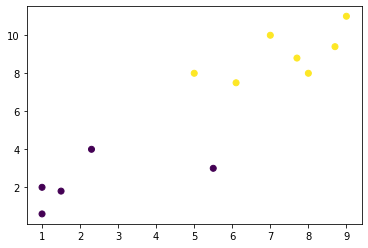

In [4]:
# shaping data for training the model
training_X = np.vstack((X, y)).T
training_y = [0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1]
plt.scatter(X, y, c=training_y) 
plt.show()

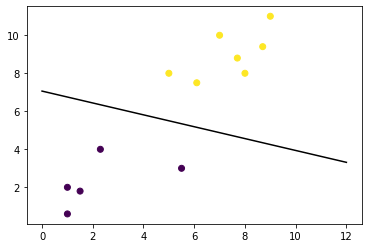

In [5]:
# define the model
model = svm.SVC(gamma='scale', kernel='linear')
model.fit(training_X, training_y)
xWeight, yWeight = model.coef_[0]
a = -xWeight / yWeight # slope
xx = np.linspace(0, 12) # creating X points
# here intercept_ is constant so basically thats ax - c
yy = a*xx - model.intercept_[0]/yWeight
plt.scatter(X, y, c=training_y) 
plt.plot(xx, yy, 'k-')
plt.show()

In [6]:
# https://towardsdatascience.com/multiclass-classification-with-support-vector-machines-svm-kernel-trick-kernel-functions-f9d5377d6f02

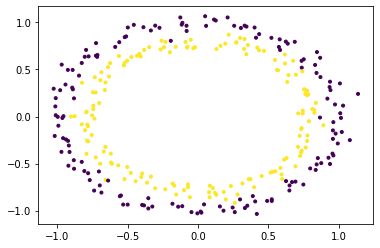

SVC(kernel='linear')

In [7]:
from sklearn import datasets
circle_X, circle_y = datasets.make_circles(n_samples=300, noise=0.05)
# show raw non-linear data
plt.scatter(circle_X[:, 0], circle_X[:, 1], c=circle_y, marker='.')
plt.show()
# make non-linear algorithm for model
model = svm.SVC(gamma='scale', kernel='linear')
# training non-linear model
model.fit(circle_X, circle_y)

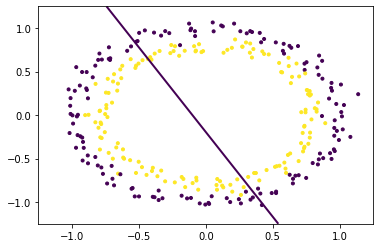

In [8]:
def plot_decision_boundary(model, ax=None):
    xx, yy = np.meshgrid(np.linspace(-1.25, 1.25, 500),
                     np.linspace(-1.25, 1.25, 500))
    Z = model.decision_function(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    contours = plt.contour(xx, yy, Z, levels=[0], linewidths=2)
    plt.scatter(circle_X[:, 0], circle_X[:, 1], c=circle_y, marker='.')
    plt.show()
plot_decision_boundary(model)

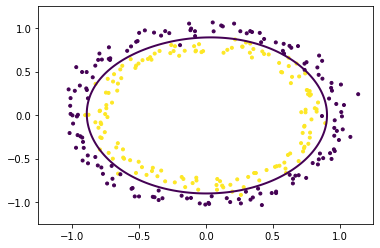

In [9]:
poly = svm.SVC(gamma='scale', kernel='rbf')
# training non-linear model
poly.fit(circle_X, circle_y)
plot_decision_boundary(poly)

In [10]:
import re
from nltk import word_tokenize
from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords, reuters
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.svm import LinearSVC
from sklearn.multiclass import OneVsRestClassifier

In [11]:
import nltk
nltk.download('stopwords')
nltk.download('reuters')
nltk.download('punkt')
! unzip /root/nltk_data/corpora/reuters.zip -d /root/nltk_data/corpora

Streaming output truncated to the last 5000 lines.
  inflating: /root/nltk_data/corpora/reuters/training/2231  
  inflating: /root/nltk_data/corpora/reuters/training/2232  
  inflating: /root/nltk_data/corpora/reuters/training/2234  
  inflating: /root/nltk_data/corpora/reuters/training/2236  
  inflating: /root/nltk_data/corpora/reuters/training/2237  
  inflating: /root/nltk_data/corpora/reuters/training/2238  
  inflating: /root/nltk_data/corpora/reuters/training/2239  
  inflating: /root/nltk_data/corpora/reuters/training/2240  
  inflating: /root/nltk_data/corpora/reuters/training/2244  
  inflating: /root/nltk_data/corpora/reuters/training/2246  
  inflating: /root/nltk_data/corpora/reuters/training/2247  
  inflating: /root/nltk_data/corpora/reuters/training/2249  
  inflating: /root/nltk_data/corpora/reuters/training/225  
  inflating: /root/nltk_data/corpora/reuters/training/2251  
  inflating: /root/nltk_data/corpora/reuters/training/2252  
  inflating: /root/nltk_data/corpor

In [12]:
stop_words = stopwords.words("english")
stemmer = PorterStemmer()
word_re = re.compile('[a-zA-Z]+')
min_length = 3
def tokenize(text):
  words = []
  for word in word_tokenize(text):
    word = word.lower()
    if word not in stop_words:
      stemmed_word = stemmer.stem(word)
      if len(stemmed_word) >= min_length and word_re.match(stemmed_word):
        words.append(stemmed_word)
  return words

In [13]:
docs = reuters.fileids()
train_docs_id = list(filter(lambda _: _.startswith('training/'),
docs))
test_docs_id = list(filter(lambda _: _.startswith('test/'),
docs))

In [14]:
train_docs = list(map(reuters.raw, train_docs_id))
test_docs = list(map(reuters.raw, test_docs_id))

# Tokenisation
# https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html
vectorizer = TfidfVectorizer(stop_words = stop_words, tokenizer = tokenize)

# Learn and transform train documents
vectorised_train_documents = vectorizer.fit_transform(train_docs)
vectorised_test_documents = vectorizer.transform(test_docs)

vectorised_train_documents

/usr/local/lib/python3.7/dist-packages/sklearn/feature_extraction/text.py:401: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['could', 'might', 'must', "n't", 'need', 'sha', 'would'] not in stop_words.
  % sorted(inconsistent)


<7769x20684 sparse matrix of type '<class 'numpy.float64'>'
	with 370244 stored elements in Compressed Sparse Row format>

In [15]:
vectorised_train_documents

<7769x20684 sparse matrix of type '<class 'numpy.float64'>'
	with 370244 stored elements in Compressed Sparse Row format>

In [16]:
mlb = MultiLabelBinarizer() # since our data can have more than one labels, we're creating label matrix
# https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MultiLabelBinarizer.html
# there is a good example in above link to get it
train_labels = mlb.fit_transform([reuters.categories(doc_id) for doc_id in train_docs_id])
test_labels = mlb.transform([reuters.categories(doc_id) for doc_id in test_docs_id])

classifier = OneVsRestClassifier(LinearSVC(random_state=30))
classifier.fit(vectorised_train_documents, train_labels)
 
predictions = classifier.predict(vectorised_test_documents)

No handles with labels found to put in legend.


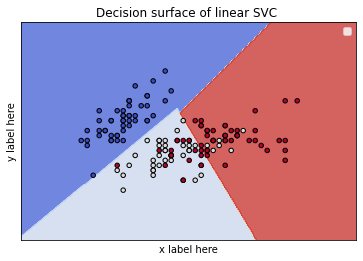

In [17]:
iris = datasets.load_iris()
# Select 2 features / variable for the 2D plot that we are going to create.
X = iris.data[:, :2]  # we only take the first two features.
y = iris.target

def make_meshgrid(x, y, h=.02):
    x_min, x_max = x.min() - 1, x.max() + 1
    y_min, y_max = y.min() - 1, y.max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    return xx, yy

def plot_contours(ax, clf, xx, yy, **params):
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    out = ax.contourf(xx, yy, Z, **params)
    return out

model = svm.SVC(kernel='linear')
clf = model.fit(X, y)

fig, ax = plt.subplots()
# title for the plots
title = ('Decision surface of linear SVC ')
# Set-up grid for plotting.
X0, X1 = X[:, 0], X[:, 1]
xx, yy = make_meshgrid(X0, X1)

plot_contours(ax, clf, xx, yy, cmap=plt.cm.coolwarm, alpha=0.8)
ax.scatter(X0, X1, c=y, cmap=plt.cm.coolwarm, s=20, edgecolors='k')
ax.set_ylabel('y label here')
ax.set_xlabel('x label here')
ax.set_xticks(())
ax.set_yticks(())
ax.set_title(title)
ax.legend()
plt.show()


No handles with labels found to put in legend.


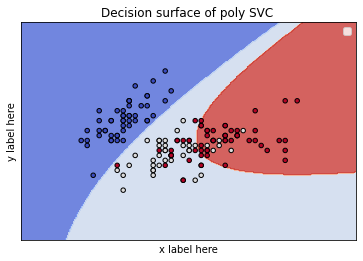

In [18]:
model = svm.SVC(kernel='poly', gamma=1, C=1, decision_function_shape='ovo')
clf = model.fit(X, y)

fig, ax = plt.subplots()
# title for the plots
title = ('Decision surface of poly SVC ')
# Set-up grid for plotting.
X0, X1 = X[:, 0], X[:, 1]
xx, yy = make_meshgrid(X0, X1)

plot_contours(ax, clf, xx, yy, cmap=plt.cm.coolwarm, alpha=0.8)
ax.scatter(X0, X1, c=y, cmap=plt.cm.coolwarm, s=20, edgecolors='k')
ax.set_ylabel('y label here')
ax.set_xlabel('x label here')
ax.set_xticks(())
ax.set_yticks(())
ax.set_title(title)
ax.legend()
plt.show()

No handles with labels found to put in legend.


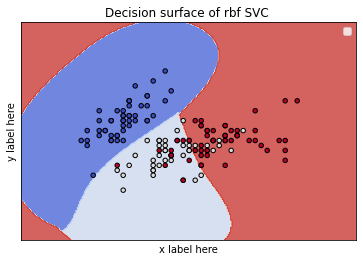

In [19]:
model = svm.SVC(kernel='rbf', gamma=1, C=1, decision_function_shape='ovo')
clf = model.fit(X, y)

fig, ax = plt.subplots()
# title for the plots
title = ('Decision surface of rbf SVC ')
# Set-up grid for plotting.
X0, X1 = X[:, 0], X[:, 1]
xx, yy = make_meshgrid(X0, X1)

plot_contours(ax, clf, xx, yy, cmap=plt.cm.coolwarm, alpha=0.8)
ax.scatter(X0, X1, c=y, cmap=plt.cm.coolwarm, s=20, edgecolors='k')
ax.set_ylabel('y label here')
ax.set_xlabel('x label here')
ax.set_xticks(())
ax.set_yticks(())
ax.set_title(title)
ax.legend()
plt.show()

No handles with labels found to put in legend.


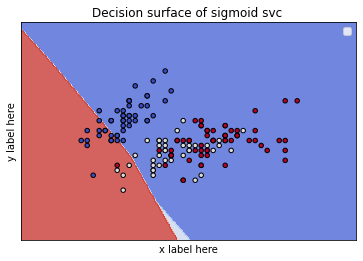

In [20]:
model = svm.SVC(kernel='sigmoid')
clf = model.fit(X, y)

fig, ax = plt.subplots()
# title for the plots
title = ('Decision surface of sigmoid svc ')
# Set-up grid for plotting.
X0, X1 = X[:, 0], X[:, 1]
xx, yy = make_meshgrid(X0, X1)

plot_contours(ax, clf, xx, yy, cmap=plt.cm.coolwarm, alpha=0.8)
ax.scatter(X0, X1, c=y, cmap=plt.cm.coolwarm, s=20, edgecolors='k')
ax.set_ylabel('y label here')
ax.set_xlabel('x label here')
ax.set_xticks(())
ax.set_yticks(())
ax.set_title(title)
ax.legend()
plt.show()